# Kaggle dataset link - 'https://www.kaggle.com/datasets/pkdarabi/cardetection

In [1]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompati

# **Import Modules**

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# **Load the Data**

In [3]:
BASE_DIR = "/kaggle/input/cardetection/car"

train_dir = os.path.join(BASE_DIR, "train")
valid_dir = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test")

IMG_SIZE = 224

# **Data Preprocessing**

# ==========================================================
# LOAD IMAGES + YOLO LABELS
# YOLO label format per line:
# class x_center y_center width height
# Convert to: xmin ymin xmax ymax  (normalized)
# If multiple objects exist, take the largest bbox
# ==========================================================

In [4]:
def load_images_and_bboxes(img_dir, label_dir, img_size=(224, 224)):
    images = []
    bboxes = []

    for filename in os.listdir(img_dir):

        if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        # ---- Load image ----
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, img_size)
        img = img.astype("float32") / 255.0
        images.append(img)

        # ---- Build label path ----
        name, _ = os.path.splitext(filename)
        label_path = os.path.join(label_dir, name + ".txt")

        # ---- Read YOLO label ----
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            if len(lines) > 0:
                best_bbox = None
                best_area = 0

                for line in lines:
                    parts = line.strip().split()

                    if len(parts) != 5:
                        continue

                    _, xc, yc, bw, bh = map(float, parts)

                    # YOLO -> xmin ymin xmax ymax
                    x_min = xc - bw / 2
                    y_min = yc - bh / 2
                    x_max = xc + bw / 2
                    y_max = yc + bh / 2

                    # Clip bbox to [0,1]
                    x_min = max(0, x_min)
                    y_min = max(0, y_min)
                    x_max = min(1, x_max)
                    y_max = min(1, y_max)

                    area = bw * bh

                    if area > best_area:
                        best_area = area
                        best_bbox = [x_min, y_min, x_max, y_max]

                if best_bbox is not None:
                    bboxes.append(best_bbox)
                else:
                    bboxes.append([0, 0, 0, 0])

            else:
                bboxes.append([0, 0, 0, 0])

        else:
            bboxes.append([0, 0, 0, 0])

    return np.array(images), np.array(bboxes)

In [5]:
X_train, y_train = load_images_and_bboxes(
    os.path.join(train_dir, "images"),
    os.path.join(train_dir, "labels"),
    img_size=(IMG_SIZE, IMG_SIZE)
)

X_valid, y_valid = load_images_and_bboxes(
    os.path.join(valid_dir, "images"),
    os.path.join(valid_dir, "labels"),
    img_size=(IMG_SIZE, IMG_SIZE)
)

X_test, y_test = load_images_and_bboxes(
    os.path.join(test_dir, "images"),
    os.path.join(test_dir, "labels"),
    img_size=(IMG_SIZE, IMG_SIZE)
)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (3530, 224, 224, 3) (3530, 4)
Valid: (801, 224, 224, 3) (801, 4)
Test : (638, 224, 224, 3) (638, 4)


# **VISUALIZATION FUNCTION**

In [6]:
def show_random_bbox(images, bboxes):
    idx = random.randint(0, len(images) - 1)

    img = images[idx].copy()
    bbox = bboxes[idx]

    h, w = img.shape[:2]
    x_min, y_min, x_max, y_max = bbox

    # Convert normalized -> pixel
    x_min = int(x_min * w)
    y_min = int(y_min * h)
    x_max = int(x_max * w)
    y_max = int(y_max * h)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bbox
    if x_max > x_min and y_max > y_min:
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 1, 0), 2)
    else:
        print("⚠️ Invalid bbox")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Index: {idx}")
    plt.show()


Train Random Image


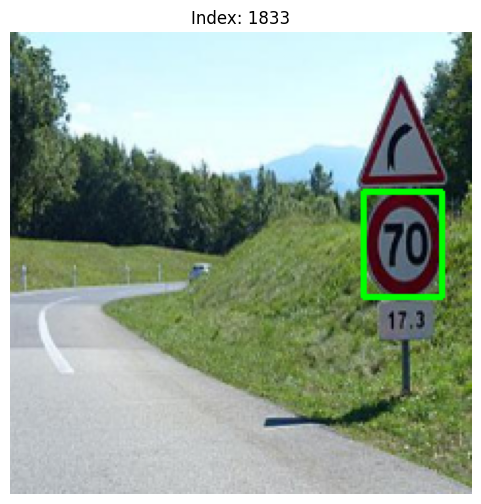

Valid Random Image


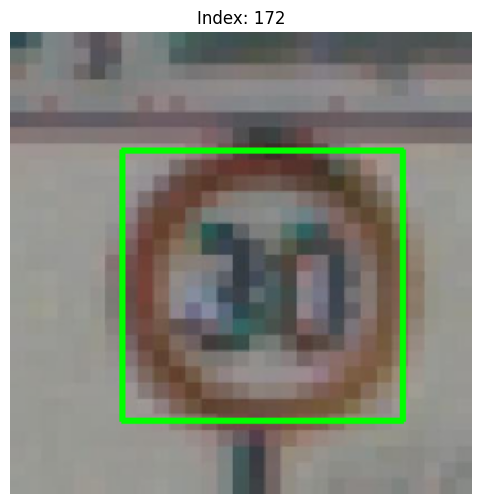

Test Random Image


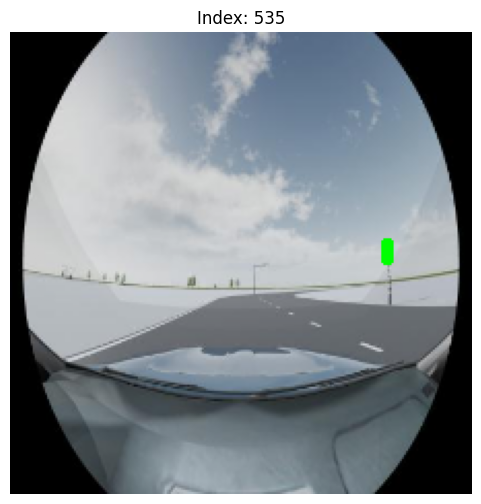

In [7]:
print("Train Random Image")
show_random_bbox(X_train, y_train)

print("Valid Random Image")
show_random_bbox(X_valid, y_valid)

print("Test Random Image")
show_random_bbox(X_test, y_test)


In [8]:
def show_bbox_grid(images, bboxes, n=9):
    plt.figure(figsize=(12, 12))

    for i in range(n):
        idx = random.randint(0, len(images) - 1)

        img = images[idx].copy()
        bbox = bboxes[idx]

        h, w = img.shape[:2]
        x_min, y_min, x_max, y_max = bbox

        # Convert normalized -> pixel
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bbox
        if x_max > x_min and y_max > y_min:
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 1, 0), 2)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Index: {idx}", fontsize=8)

    plt.show()


--- Train Ground Truth Samples ---


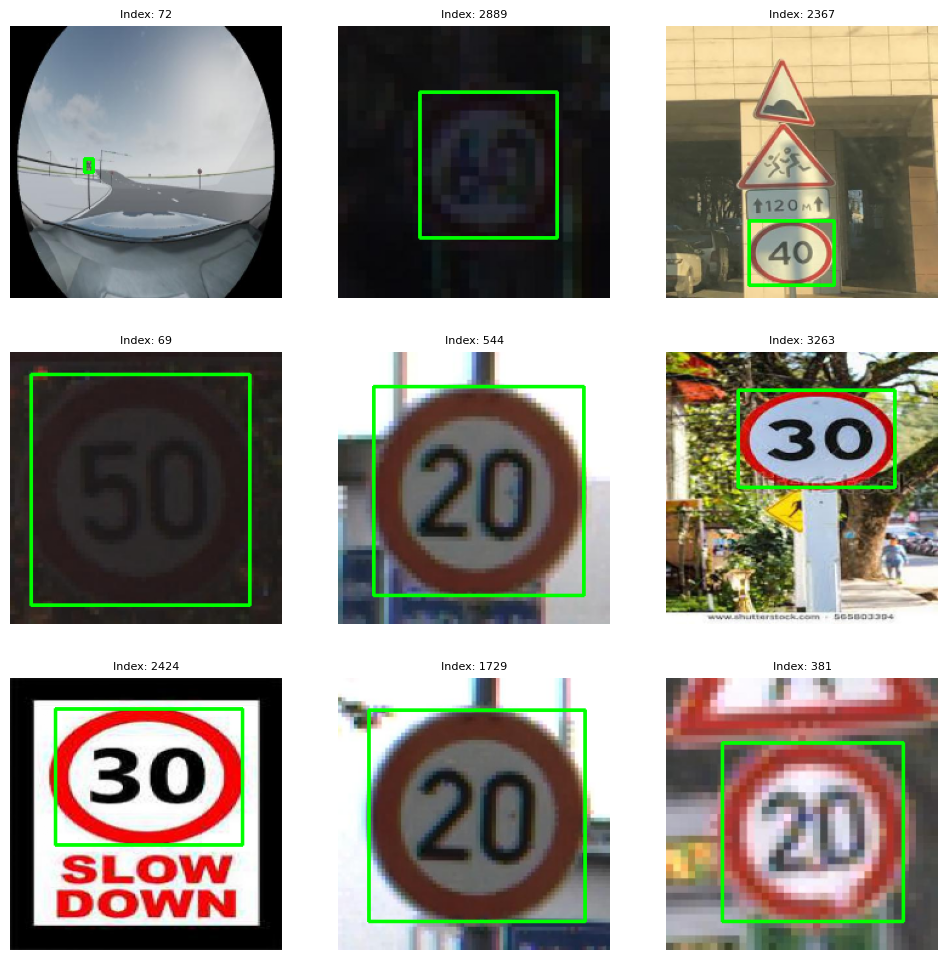

In [9]:
print("\n--- Train Ground Truth Samples ---")
show_bbox_grid(X_train, y_train)


--- Valid Ground Truth Samples ---


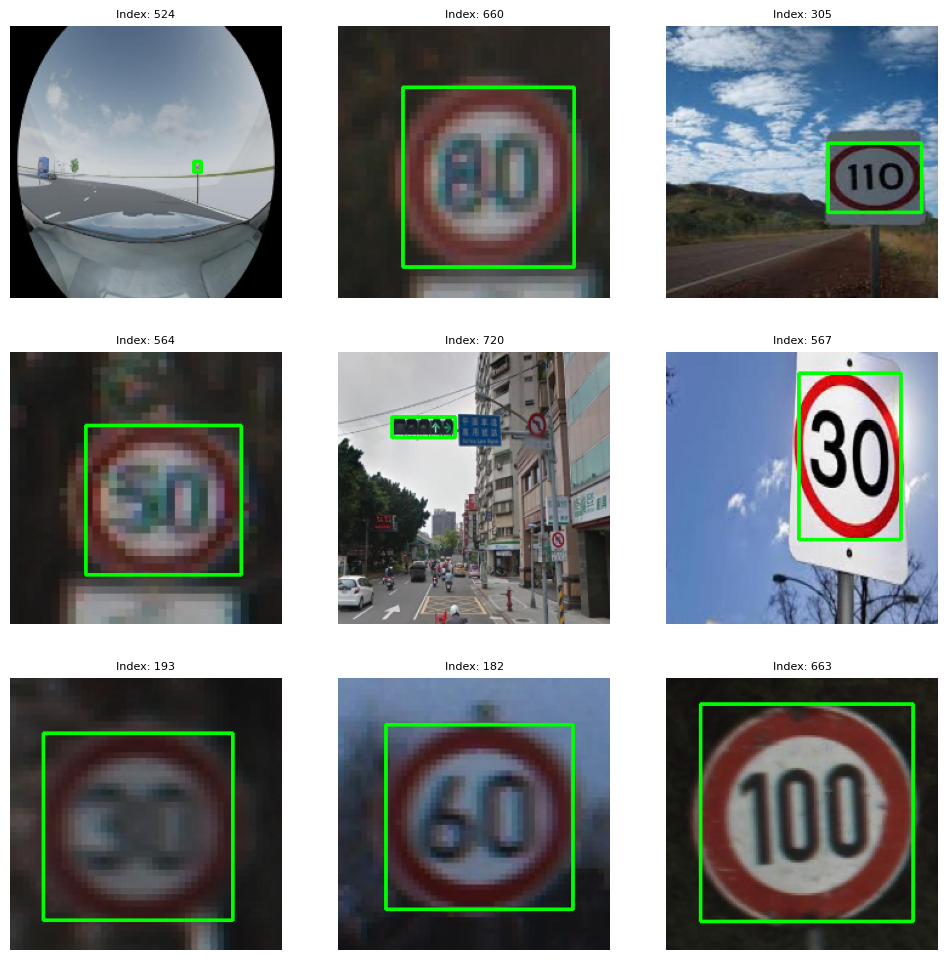

In [10]:
print("\n--- Valid Ground Truth Samples ---")
show_bbox_grid(X_valid, y_valid)

# **MODEL BUILDING (TRANSFER LEARNING)**

In [11]:

# -------------------------------
# Load ResNet50 Backbone
# -------------------------------
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

# -------------------------------
# Add Custom Head
# -------------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)

# Output: xmin, ymin, xmax, ymax (normalized)
outputs = Dense(4, activation="sigmoid")(x)

# -------------------------------
# Build Model
# -------------------------------
model = Model(inputs=base_model.input, outputs=outputs)

# -------------------------------
# Compile Model
# -------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

model.summary()

I0000 00:00:1770282363.640498      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770282363.643743      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# TRAIN MODEL

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=32
)


Epoch 1/10
  1/111 ━━━━━━━━━━━━━━━━━━━━ 28:48 16s/step - loss: 0.0405 - mean_absolute_error: 0.2266

I0000 00:00:1770282387.778391      77 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - loss: 0.0282 - mean_absolute_error: 0.1877 - val_loss: 0.0158 - val_mean_absolute_error: 0.1494
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0190 - mean_absolute_error: 0.1558 - val_loss: 0.0140 - val_mean_absolute_error: 0.1367
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0153 - mean_absolute_error: 0.1405 - val_loss: 0.0126 - val_mean_absolute_error: 0.1258
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0142 - mean_absolute_error: 0.1328 - val_loss: 0.0117 - val_mean_absolute_error: 0.1196
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0127 - mean_absolute_error: 0.1245 - val_loss: 0.0112 - val_mean_absolute_error: 0.1120
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.0123 - mean_absolute_error: 0.1196 - val_loss: 0.0106 - val_mean_absolute_error: 0.1089
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.0120 - mean_absolute_error: 0.

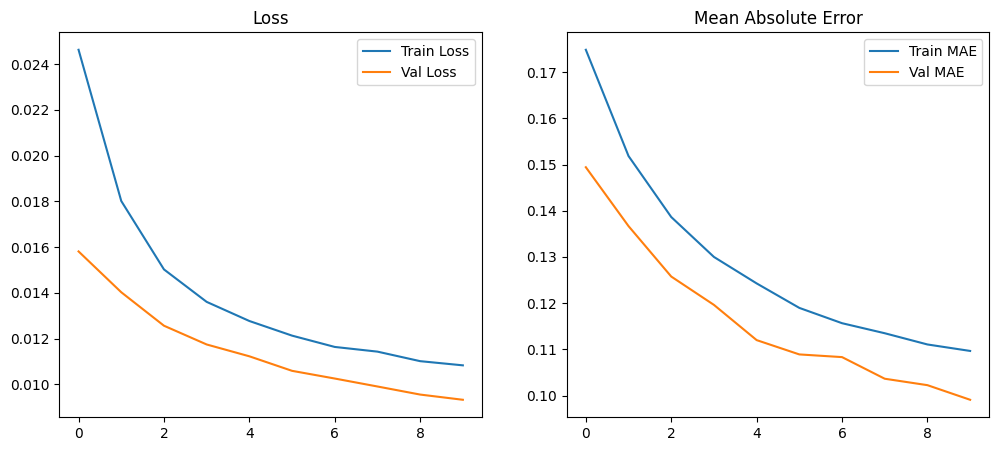

In [13]:
# PLOT LOSS + MAE


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Val MAE")
plt.title("Mean Absolute Error")
plt.legend()

plt.show()


# **TEST EVALUATION**

In [14]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\n✅ Test MAE: {test_mae:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - loss: 0.0110 - mean_absolute_error: 0.1084

✅ Test MAE: 0.1061
✅ Test Loss: 0.0107


In [15]:
# PREDICT + VISUALIZE ON ANY IMAGE

def predict_and_visualize(model, image_path):
    image = cv2.imread(image_path)

    if image is None:
        print("❌ Image not found:", image_path)
        return

    h, w = image.shape[:2]

    img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input, verbose=0)[0]
    print("Predicted (normalized):", pred)

    # Fix bbox ordering
    x1, y1, x2, y2 = pred
    x_min, x_max = min(x1, x2), max(x1, x2)
    y_min, y_max = min(y1, y2), max(y1, y2)

    # Convert normalized -> pixel
    x_min = int(x_min * w)
    y_min = int(y_min * h)
    x_max = int(x_max * w)
    y_max = int(y_max * h)

    if x_max <= x_min or y_max <= y_min:
        print("⚠️ Invalid predicted bbox")
        return

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



--- Prediction on Random Test Image ---
Image Path: /kaggle/input/cardetection/car/test/images/FisheyeCamera_1_00594_png.rf.dc0e60f4633360af03461b14c31a1454.jpg
Predicted (normalized): [0.46656856 0.4450239  0.5525675  0.5294328 ]


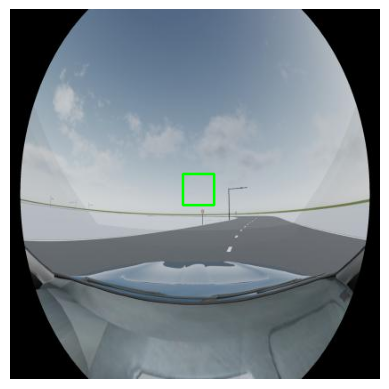

In [16]:
# TEST PREDICTION ON RANDOM TEST IMAGE

test_images_dir = os.path.join(test_dir, "images")
random_test_image = random.choice(os.listdir(test_images_dir))
random_test_path = os.path.join(test_images_dir, random_test_image)

print("\n--- Prediction on Random Test Image ---")
print("Image Path:", random_test_path)

predict_and_visualize(model, random_test_path)


--- 9 Random Test Predictions ---


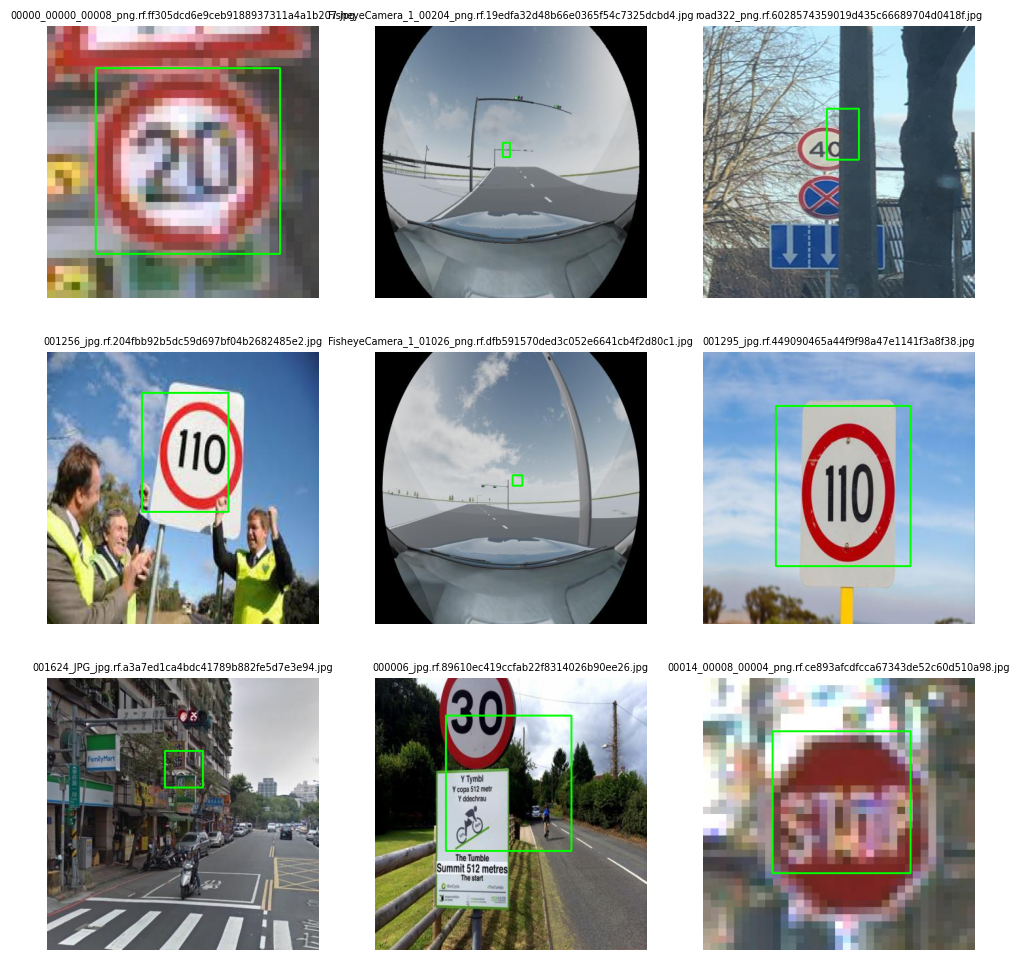

In [17]:
# PREDICT GRID (9 random test images)

def predict_bbox_grid(model, images_dir, n=9):
    plt.figure(figsize=(12, 12))

    for i in range(n):
        img_name = random.choice(os.listdir(images_dir))
        img_path = os.path.join(images_dir, img_name)

        image = cv2.imread(img_path)
        if image is None:
            continue

        h, w = image.shape[:2]

        img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        img_norm = img_resized.astype("float32") / 255.0
        img_input = np.expand_dims(img_norm, axis=0)

        pred = model.predict(img_input, verbose=0)[0]

        x1, y1, x2, y2 = pred
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)

        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)

        if x_max > x_min and y_max > y_min:
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_rgb)
        plt.title(img_name, fontsize=7)
        plt.axis("off")

    plt.show()


print("\n--- 9 Random Test Predictions ---")
predict_bbox_grid(model, test_images_dir, n=9)

In [18]:
# Saving the model

# model.save("bbox_resnet_model_upd.h5")
# print("✅ Model saved successfully!")

In [19]:
# Opencv Webcam code

# import cv2
# import numpy as np
# import tensorflow as tf

# IMG_SIZE = 224   # same as training

# # -------------------------------
# # Load trained model
# # -------------------------------
# model = tf.keras.models.load_model("bbox_resnet_model.h5")
# # or if model already exists, skip loading

# print("✅ Bounding Box model loaded")

# # -------------------------------
# # Start Webcam
# # -------------------------------
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("❌ Error: Cannot open webcam")
#     exit()

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     h, w = frame.shape[:2]

#     # -------------------------------
#     # Preprocess frame
#     # -------------------------------
#     img_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
#     img_norm = img_resized.astype("float32") / 255.0
#     img_input = np.expand_dims(img_norm, axis=0)

#     # -------------------------------
#     # Predict bbox
#     # -------------------------------
#     pred = model.predict(img_input, verbose=0)[0]

#     # Fix bbox ordering
#     x1, y1, x2, y2 = pred
#     x_min, x_max = min(x1, x2), max(x1, x2)
#     y_min, y_max = min(y1, y2), max(y1, y2)

#     # Convert normalized -> pixel
#     x_min = int(x_min * w)
#     y_min = int(y_min * h)
#     x_max = int(x_max * w)
#     y_max = int(y_max * h)

#     # Clip to frame size
#     x_min = max(0, x_min)
#     y_min = max(0, y_min)
#     x_max = min(w, x_max)
#     y_max = min(h, y_max)

#     # -------------------------------
#     # Draw bbox
#     # -------------------------------
#     if x_max > x_min and y_max > y_min:
#         cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
#         cv2.putText(frame, "Detected", (x_min, y_min - 10),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

#     # -------------------------------
#     # Show Output
#     # -------------------------------
#     cv2.imshow("Webcam Bounding Box Detection (ResNet50)", frame)

#     # ESC to exit
#     if cv2.waitKey(1) & 0xFF == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()
